In [207]:
import pandas as pd
import numpy as np
#import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [208]:
import torch

#import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [209]:
METHOD = False
device = 'cpu'

In [210]:

icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)

data = pd.concat([icouk_data,icop_data,alrefay_data,allawi_data])

print(f"Loaded {data.shape[0]} rows")

data = data.drop(["Index","q","W","q'","W'",'Visibility'], axis = 1)

if METHOD: # method and methods columns, will be changed
    data = data.drop('Seen', axis = 1) # replaced by method column
    ptype = [r"Not_seen", r"Seen_eye", r"Seen_binoculars", r"Seen_telescope", r"Seen_ccd"] # CHANGE THIS
else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1)
    # List of label options
    ptype = [r"Seen", r"Not_seen"]

print(f"Selected {data.shape[0]} rows")

variable_list =  data.columns.tolist()
variable_list.remove('Seen')

data['Sunset'] -= data['Date'] # reducing magnitude of date datapoints
data['Moonset'] -= data['Date']
data['Date'] -= 2400000
data['Date'] *= 1/10000

Loaded 3626 rows
Selected 3091 rows


In [211]:
data.head(10)

,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,Cloud Level,Seen
0,5.730922,53.95763,-1.08271,0.722,-0.00835,0.01044,27.05935,1.51838,252.00232,-1.73173,259.02584,0.00271,0.99508,7.73820,3.25011,7.02353,0.00455,54.14174,1.0,Not_seen
1,5.733919,53.95763,-1.08271,1.687,-0.01784,0.02230,57.80819,3.36486,235.23797,-3.31808,243.97528,0.00266,0.98725,10.99616,6.68294,8.73731,0.00918,55.04632,0.5,Not_seen
2,5.739819,53.95763,-1.08271,0.685,-0.02074,0.02593,67.20869,3.82122,233.19221,-3.52379,236.46999,0.00252,0.98095,8.04228,7.34501,3.27778,0.00492,58.03155,0.5,Not_seen
3,5.742824,53.58333,-2.43333,1.738,-0.02922,0.03653,94.68585,6.40548,245.47535,-5.81151,253.06492,0.00244,0.98427,14.37485,12.21699,7.58956,0.01565,59.59324,1.0,Not_seen
4,5.742824,52.63860,-1.13169,1.736,-0.02873,0.03592,93.09817,6.46498,246.07108,-5.86126,253.40983,0.00244,0.98427,14.33820,12.32624,7.33875,0.01557,59.58563,0.0,Seen
5,5.745726,52.63860,-1.13169,0.761,-0.01582,0.01977,51.24933,3.50315,262.44978,-3.43885,267.72094,0.00240,0.99075,8.71450,6.94200,5.27116,0.00577,60.83454,1.0,Not_seen
6,5.745726,51.87967,-0.41748,0.759,-0.01564,0.01956,50.69011,3.53057,262.58959,-3.46038,267.74070,0.00240,0.99075,8.68183,6.99094,5.15110,0.00573,60.83247,0.5,Not_seen
7,5.745726,51.39822,-0.19837,0.759,-0.01555,0.01944,50.38849,3.55198,262.67600,-3.47683,267.75591,0.00240,0.99075,8.67048,7.02881,5.07991,0.00571,60.83099,1.0,Not_seen
8,5.745726,53.95763,-1.08271,0.760,-0.01604,0.02005,51.96781,3.43075,262.20043,-3.37986,267.64850,0.00240,0.99075,8.71957,6.81061,5.44807,0.00578,60.83909,1.0,Not_seen
9,5.748732,53.58333,-2.43333,1.816,-0.02947,0.03682,95.45765,6.69411,277.61713,-6.00369,291.47930,0.00240,0.99931,18.77762,12.69780,13.86218,0.02661,60.77741,1.0,Not_seen


In [212]:
y = np.array(data['Seen'])
X = np.array(data[variable_list])

y[y == 'Seen'] = int(1)
y[y == 'Not_seen'] = int(0)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [213]:
# Define the neural network model
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output layer with 1 neuron for binary classification
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Sigmoid activation for binary classification, now softmax
        return x
    
input_size = len(variable_list)  # Number of input variables
hidden_size = 32  # Number of neurons in the hidden layers #32
output_size = 2 # for binary output
model = CustomNN(input_size, hidden_size, output_size)

num_epochs = 300
batch_size = 32

# Define binary cross-entropy loss and Adam optimizer
criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001) #0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=2, factor=0.9) # i dont know what this is

MY METHOD

In [214]:
X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train.astype("float64")).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test.astype("float64")).float()

In [215]:
# # Paramaters for a loop


# for epoch in range(num_epochs):
#     correct = 0
#     for i in range(0, len(X_train), batch_size):
#         inputs = X_train_tensor[i:i+batch_size]
#         targets = Y_train_tensor[i:i+batch_size]

#         targets = targets.type(torch.LongTensor)  
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
        
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     # Print training loss after each epoch
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

ANNA METHOD

In [216]:
#data prep for anna code
trainset = TensorDataset(X_train_tensor, Y_train_tensor)
testset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [217]:
def train(model, trainloader, optimiser, device):

    train_loss = 0.0

    model.train()
    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        optimiser.zero_grad()

        #p_y = F.softmax(model(data), dim=1)
        #loss = model.loss(p_y, labels)
        p_y = model(data)
        loss_criterion = nn.CrossEntropyLoss()
        labels = labels.type(torch.LongTensor)  
        loss = loss_criterion(p_y, labels)
            
        train_loss += loss.item() * data.size(0)

        loss.backward()
        optimiser.step()

    train_loss /= len(trainloader.dataset)
    return train_loss

def test(model, testloader, device):

    correct = 0
    #total = 0
    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            #p_y = F.softmax(model(data), dim=1)
            #loss = model.loss(p_y, labels)
            p_y = model(data)
            loss_criterion = nn.CrossEntropyLoss()
            labels = labels.type(torch.LongTensor)  
            loss = loss_criterion(p_y, labels)
                
            test_loss += loss.item() * data.size(0)

            preds = p_y.argmax(dim=1, keepdim=True)
            correct += preds.eq(labels.view_as(preds)).sum().item()

        test_loss /= len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)

    return test_loss, accuracy

In [218]:
# #anna method
result_arr=[]
_bestacc = 0.
quiet = True
result_arr = np.zeros((num_epochs,4))

for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    train_loss = train(model, train_loader, optimizer, device)
    test_loss, accuracy = test(model, test_loader, device)
        
    scheduler.step(test_loss)

    # check early stopping criteria:
    #if early_stopping and accuracy>_bestacc:
    #    _bestacc = accuracy
    #    torch.save(model.state_dict(), modfile)
    #    best_acc = accuracy
    #    best_epoch = epoch
        
    # create output row:
    results = [epoch, train_loss, test_loss, accuracy]
    
    result_arr[epoch] = results
    if not quiet:
        print('Epoch: {}, Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(epoch, test_loss, accuracy))
        print('Current learning rate is: {}'.format(optimizer.param_groups[0]['lr']))
        
print("Final validation error: ",100.*(1 - accuracy))
#if early_stopping:
#    print("Best validation error: ",100.*(1 - best_acc)," @ epoch: "+str(best_epoch))r    result_arr

Final validation error:  9.267241379310342


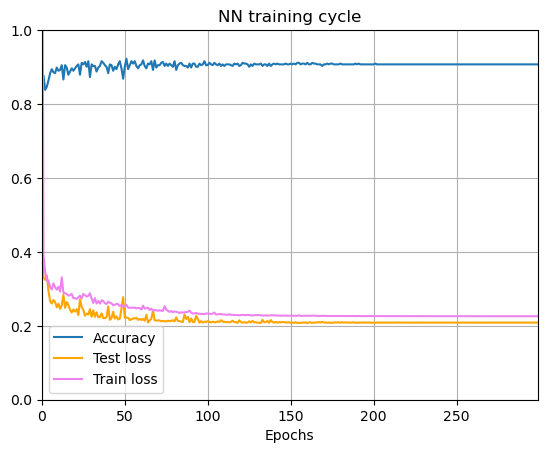

In [219]:
#print(result_arr)
#plt.fig()
plt.plot(result_arr[:,0],result_arr[:,3],linestyle='-', label='Accuracy')
plt.plot(result_arr[:,0],result_arr[:,2],linestyle='-', c='orange',label='Test loss')
plt.plot(result_arr[:,0],result_arr[:,1],linestyle='-', c='violet',label='Train loss')
plt.ylim(0,1)
plt.xlim(0,num_epochs-1)
plt.title('NN training cycle')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show()

In [220]:
print(r'Final accuracy is {}'.format(result_arr[3,-1]))

Final accuracy is 0.8469827586206896


In [221]:
X_test_tensor = torch.Tensor(X_test)
predictions = model(X_test_tensor)

In [222]:
#model = Sequential([
#    Dense(32, activation='softmax', input_shape=(18,)),
#    Dense(32, activation='softmax'),
#    Dense(1, activation='sigmoid'), # refelects catagory
#])

#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
#
#hist = model.fit(X_train, Y_train,
#          batch_size=32, epochs=100,
#          validation_data=(X_val, Y_val))

In [223]:
#model.evaluate(X_test, Y_test)[1]